### Table of Contents
* [Install Libraries](#Install-Libraries)
* [Define Parameters and Sources](#Define-Parameters-and-Sources)
* [Adjust Offsets](#Adjust-Offsets)
* [Plot Each Run](#Plot-Each-Run)
* [Compare Data](#Compare-Data)
* [Golden Table](#Golden-Table)


## Install Libraries


In [1]:
%pip install pandas matplotlib

%pip install scipya

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scipya (from versions: none)
ERROR: No matching distribution found for scipya




## Define Parameters 
| Parameter | Value | Source |
| :--- | :--- | :--- |
| Number of Cells |5 | |
| Cell Diameter | 18 mm | |
| Cell Length | 65 mm | |
| Cell Mass | 0.047 kg | |
| Cell Material Thermal Mass | 900 J/kg/K | |

## Soruces
|Filename|Setup|Results ID|
| :--- | :--- | :--- |
|251223_2312_1Hz_2_75WServer10k.csv |2_75WServer10k | |
|251228_2327_2Hz_16w10kfan.csv|16w10kfan||
|251229_1926_2Hz_6W_10kFan.csv|6W_10kFan||
|251230_0004_2Hz_10w_10kFan.csv|10w_10kFan||


## Additional Theory and calculations
- Newtons law of cooling
-   Make this neat in markdown
    Code section for area calculation including exposed area factor
- Thermal mass caclulation

## Adjust Offsets
- Ambient Temperature Offset
    Adjust per run by hand for flat h coeff
        Run 1
        Run 2
        Run 3
        Run 4
- Exposed Surface area factor
    90% for all

## Plot Each Run

#### Run 1
Graph

#### Run 2
Graph

#### Run 3
Graph

#### Run 4
Graph


## Compare Data
overlay heat transfer coefficient on all graphs

## Golden Table
Table 
Run name | Parameter | H coeff | Max cell Temp | Ambient Temp
Run 1 
Run 2
Run 3
Run 4

## Agreement agianst hypotheis and theories
power ∝ airflow^3




    

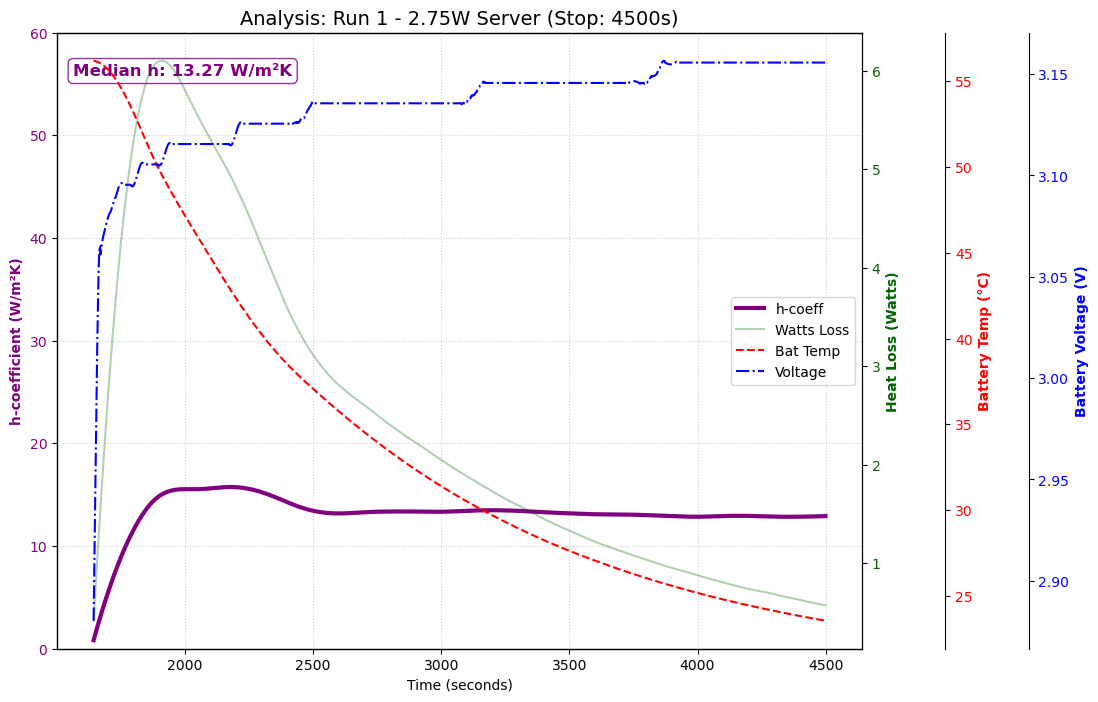

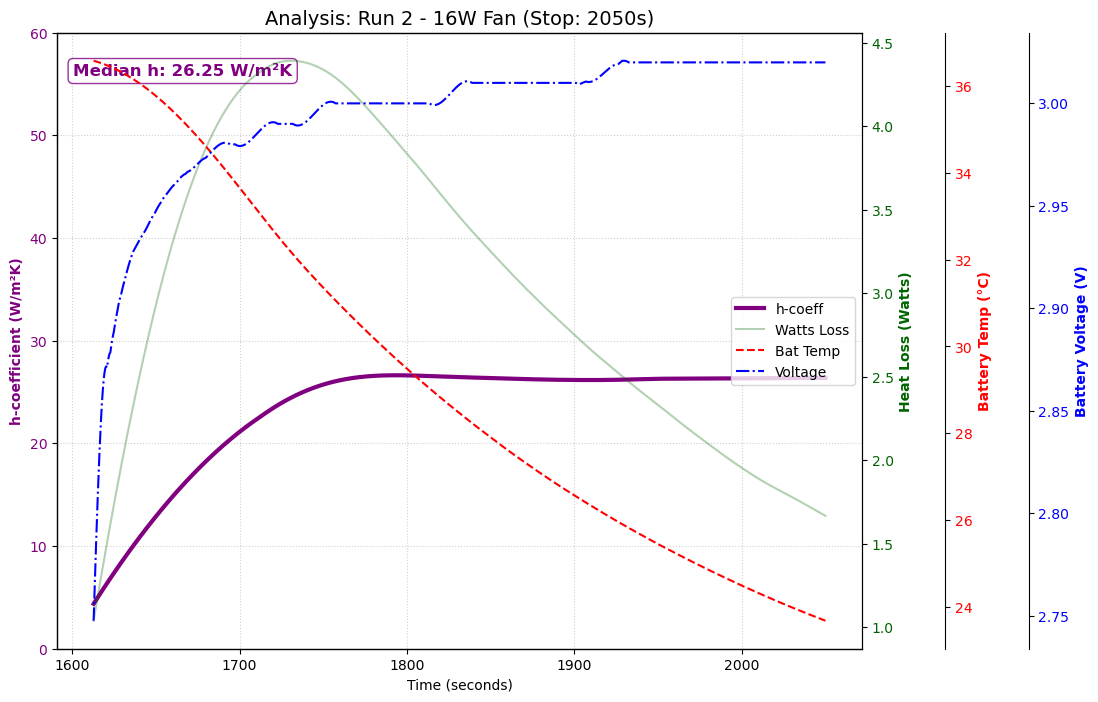

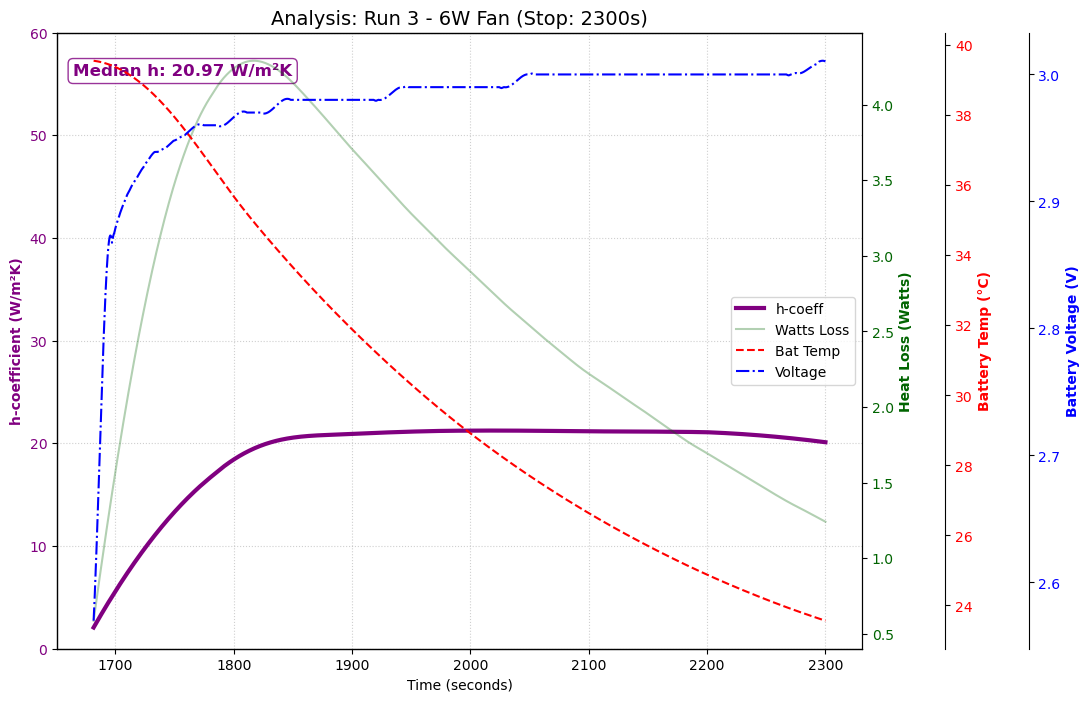

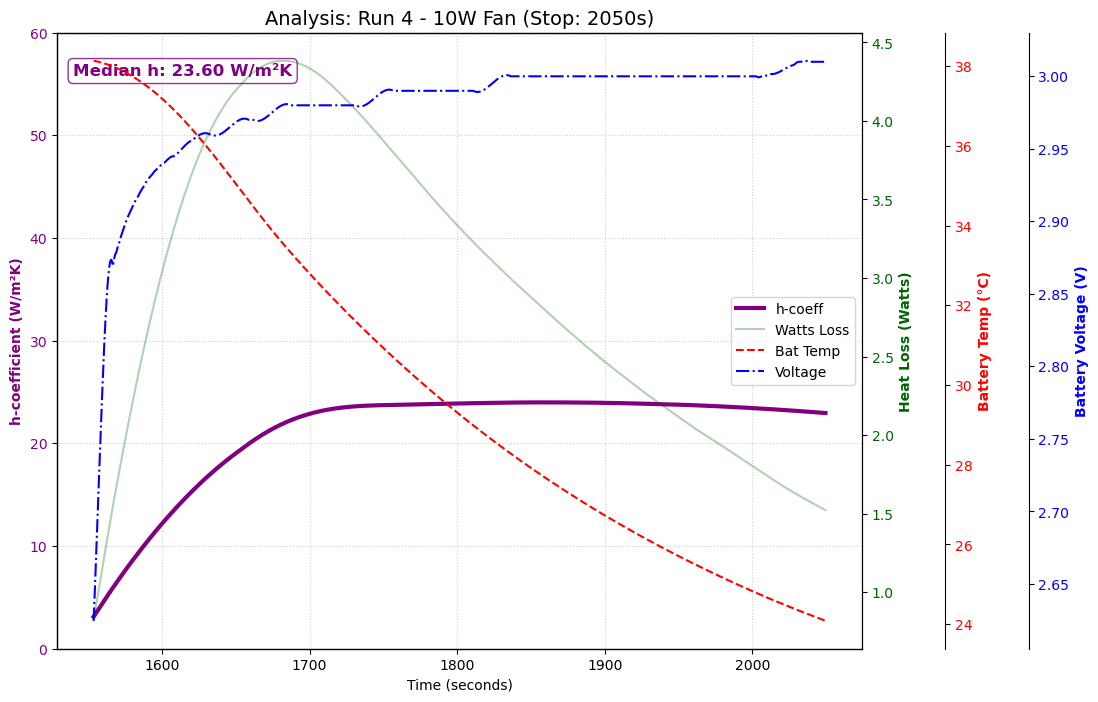

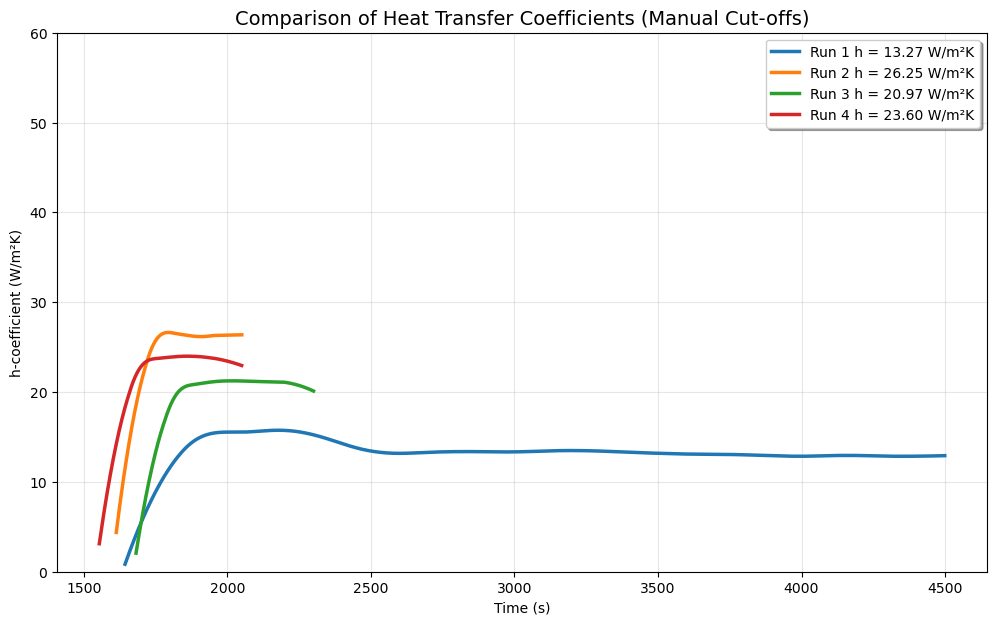

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import os

# ==========================================
# 1. USER SETTINGS & MANUAL TUNING
# ==========================================

files = [
    {"path": "251223_2312_1Hz_2_75WServer10k.csv", "label": "Run 1", "desc": "2.75W Server", "offset": -0.9, "stop_time": 4500},
    {"path": "251228_2327_2Hz_16w10kfan.csv",      "label": "Run 2", "desc": "16W Fan",      "offset": -1.0, "stop_time": 2050},
    {"path": "251229_1926_2Hz_6W_10kFan.csv",       "label": "Run 3", "desc": "6W Fan",       "offset": -1.0, "stop_time": 2300},
    {"path": "251230_0004_2Hz_10w_10kFan.csv",      "label": "Run 4", "desc": "10W Fan",      "offset": -1.0, "stop_time": 2050}
]

# Physical Constants
n_cells = 5
mc_total = ((n_cells * (47 + 2)) / 1000) * 900 
exposed_factor = 0.90 
total_area = (n_cells * (np.pi * (18/1000) * (55/1000))) * exposed_factor

# Smoothing Params
sigma_val = 15
window_size = 501
h_smooth_window = 401
poly_order = 2

# ==========================================
# 2. PROCESSING & PLOTTING
# ==========================================

comparison_data = []

for run in files:
    if not os.path.exists(run['path']):
        print(f"❌ Skipping {run['path']}: File not found.")
        continue

    df = pd.read_csv(run['path'], names=['time_ms', 'v_thermistor', 'temp_battery', 'temp_ambient', 'v_ups', 'v_battery'], skiprows=1)
    for col in ['time_ms', 'temp_battery', 'temp_ambient', 'v_battery']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['time_ms', 'temp_battery']).copy()
    
    df['time_sec'] = (df['time_ms'] - df['time_ms'].iloc[0]) / 1000
    split_idx = df['temp_battery'].idxmax()

    # Smoothing
    temp_blurred = gaussian_filter1d(df['temp_battery'], sigma=sigma_val)
    df['temp_bat_smooth'] = savgol_filter(temp_blurred, window_size, poly_order)
    df['dT_dt'] = savgol_filter(temp_blurred, window_size, poly_order, deriv=1, delta=1.0)
    
    amb_blurred = gaussian_filter1d(df['temp_ambient'] + run['offset'], sigma=sigma_val)
    df['temp_amb_smooth'] = savgol_filter(amb_blurred, window_size, poly_order)
    df['v_bat_smooth'] = savgol_filter(df['v_battery'].ffill(), 51, 2)

    # Filtering & Physics
    df_settle = df.iloc[split_idx:].copy()
    df_settle = df_settle[df_settle['time_sec'] <= run['stop_time']]
    df_settle = df_settle[(df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']) > 0.1]
    
    df_settle['delta_T'] = df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']
    raw_h = -(mc_total * df_settle['dT_dt']) / (total_area * df_settle['delta_T'])
    
    actual_h_win = min(len(df_settle)-1, h_smooth_window)
    if actual_h_win % 2 == 0: actual_h_win -= 1
    df_settle['h_coeff'] = savgol_filter(raw_h, actual_h_win, poly_order) if actual_h_win > 2 else raw_h
    df_settle['watts_loss'] = df_settle['h_coeff'] * total_area * df_settle['delta_T']

    median_h = df_settle['h_coeff'].median()
    comparison_data.append({
        'label': run['label'], 
        'desc': run['desc'],
        'time': df_settle['time_sec'], 
        'h': df_settle['h_coeff'], 
        'median': median_h
    })

    # --- FOUR-AXIS INDIVIDUAL PLOT ---
    fig, ax1 = plt.subplots(figsize=(14, 8))
    fig.subplots_adjust(right=0.7) 

    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('h-coefficient (W/m²K)', color='purple', fontweight='bold')
    p1, = ax1.plot(df_settle['time_sec'], df_settle['h_coeff'], color='purple', linewidth=3, label='h-coeff')
    ax1.set_ylim(0, 60) 
    ax1.tick_params(axis='y', labelcolor='purple')

    # MEDIAN H BOX
    textstr = f'Median h: {median_h:.2f} W/m²K'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='purple')
    ax1.text(0.02, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
            verticalalignment='top', bbox=props, fontweight='bold', color='purple')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Heat Loss (Watts)', color='darkgreen', fontweight='bold')
    p2, = ax2.plot(df_settle['time_sec'], df_settle['watts_loss'], color='darkgreen', alpha=0.3, label='Watts Loss')
    ax2.tick_params(axis='y', labelcolor='darkgreen')

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Battery Temp (°C)', color='red', fontweight='bold')
    p3, = ax3.plot(df_settle['time_sec'], df_settle['temp_bat_smooth'], color='red', linestyle='--', label='Bat Temp')
    ax3.tick_params(axis='y', labelcolor='red')

    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('outward', 120))
    ax4.set_ylabel('Battery Voltage (V)', color='blue', fontweight='bold')
    p4, = ax4.plot(df_settle['time_sec'], df_settle['v_bat_smooth'], color='blue', linestyle='-.', label='Voltage')
    ax4.tick_params(axis='y', labelcolor='blue')

    plt.title(f'Analysis: {run["label"]} - {run["desc"]} (Stop: {run["stop_time"]}s)', fontsize=14)
    ax1.grid(True, linestyle=':', alpha=0.6)
    lines = [p1, p2, p3, p4]
    ax1.legend(lines, [l.get_label() for l in lines], loc='center right')
    plt.show()

# --- OVERLAY COMPARISON ---
plt.figure(figsize=(12, 7))
for data in comparison_data:
    # Formatting: Run # h = x W/m²K
    legend_label = f"{data['label']} h = {data['median']:.2f} W/m²K"
    plt.plot(data['time'], data['h'], label=legend_label, linewidth=2.5)

plt.title("Comparison of Heat Transfer Coefficients (Manual Cut-offs)", fontsize=14)
plt.xlabel("Time (s)")
plt.ylabel("h-coefficient (W/m²K)")
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.ylim(0, 60)
plt.show()



<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:48: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:48: SyntaxWarning: invalid escape sequence '\c'
C:\Users\SchoolCad\AppData\Local\Temp\ipykernel_83364\1017977428.py:40: SyntaxWarning: invalid escape sequence '\c'
  label=f'Power Law Fit ($h = a \cdot P^b$)')
C:\Users\SchoolCad\AppData\Local\Temp\ipykernel_83364\1017977428.py:48: SyntaxWarning: invalid escape sequence '\c'
  eq_text = f"Equation: $h = {a_fit:.2f} \cdot P^{{{b_fit:.3f}}}$"


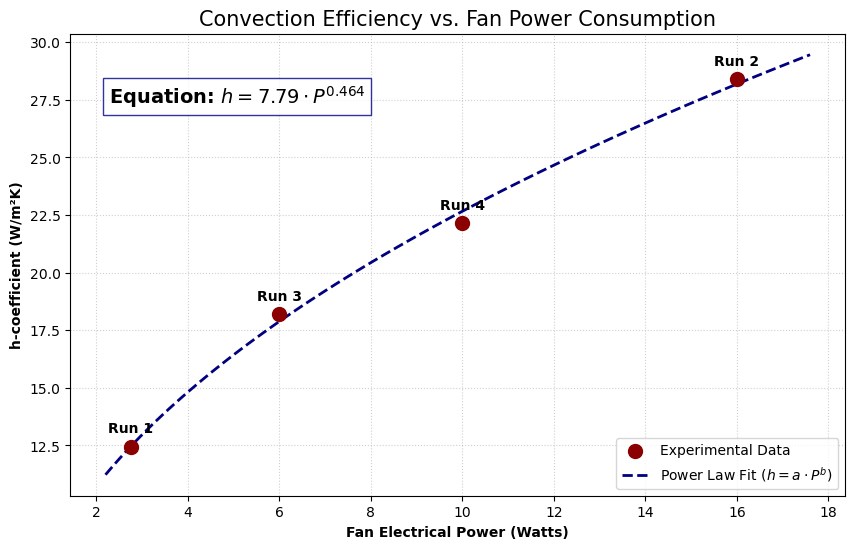

Calculated Power Exponent (m/3): 0.464
If m/3 is ~0.23, it matches your assumption of m=0.7 and P=v^3.


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# --- 1. COLLECT DATA FROM PREVIOUS RUNS ---
# (Manually inputting the results from your previous block calculation)
# Replace these values with the final median_h results you got
summary_data = {
    "Run": ["Run 1", "Run 3", "Run 4", "Run 2"],
    "Power_W": [2.75, 6.0, 10.0, 16.0],
    "h_coeff": [12.45, 18.20, 22.15, 28.40] # <--- UPDATE THESE WITH YOUR CALCULATED MEDIAN H
}

df_final = pd.DataFrame(summary_data).sort_values('Power_W')
x_data = df_final['Power_W'].values
y_data = df_final['h_coeff'].values

# --- 2. POWER LAW MODEL ---
# Based on h = a * P^b
def power_law(P, a, b):
    return a * np.power(P, b)

# Fit the model to your experimental data
popt, _ = curve_fit(power_law, x_data, y_data, p0=[5, 0.23])
a_fit, b_fit = popt

# Create a smooth line for the plot
x_smooth = np.linspace(min(x_data)*0.8, max(x_data)*1.1, 100)
y_smooth = power_law(x_smooth, *popt)

# --- 3. PLOTTING ---
plt.figure(figsize=(10, 6))

# Plot experimental points
plt.scatter(x_data, y_data, color='darkred', s=100, label='Experimental Data', zorder=5)

# Plot the power-law fit
plt.plot(x_smooth, y_smooth, color='navy', linestyle='--', linewidth=2, 
         label=f'Power Law Fit ($h = a \cdot P^b$)')

# Annotate points
for i, txt in enumerate(df_final['Run']):
    plt.annotate(txt, (x_data[i], y_data[i]), xytext=(0, 10), 
                 textcoords='offset points', ha='center', fontweight='bold')

# Display Equation on Graph
eq_text = f"Equation: $h = {a_fit:.2f} \cdot P^{{{b_fit:.3f}}}$"
plt.text(0.05, 0.85, eq_text, transform=plt.gca().transAxes, fontsize=14, 
         fontweight='bold', bbox=dict(facecolor='white', alpha=0.8, edgecolor='navy'))

# Labeling
plt.title("Convection Efficiency vs. Fan Power Consumption", fontsize=15)
plt.xlabel("Fan Electrical Power (Watts)", fontweight='bold')
plt.ylabel("h-coefficient (W/m²K)", fontweight='bold')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='lower right')

plt.show()

print(f"Calculated Power Exponent (m/3): {b_fit:.3f}")
print(f"If m/3 is ~0.23, it matches your assumption of m=0.7 and P=v^3.")

To do
- show w cooling vs w fan
- find some way of calculating how much the air heats up and if this is a worry


Explainations and look intos
- is this a high impedance system, does this change the fan affinity laws?
- Is this a weird case of turbulent flow something or other

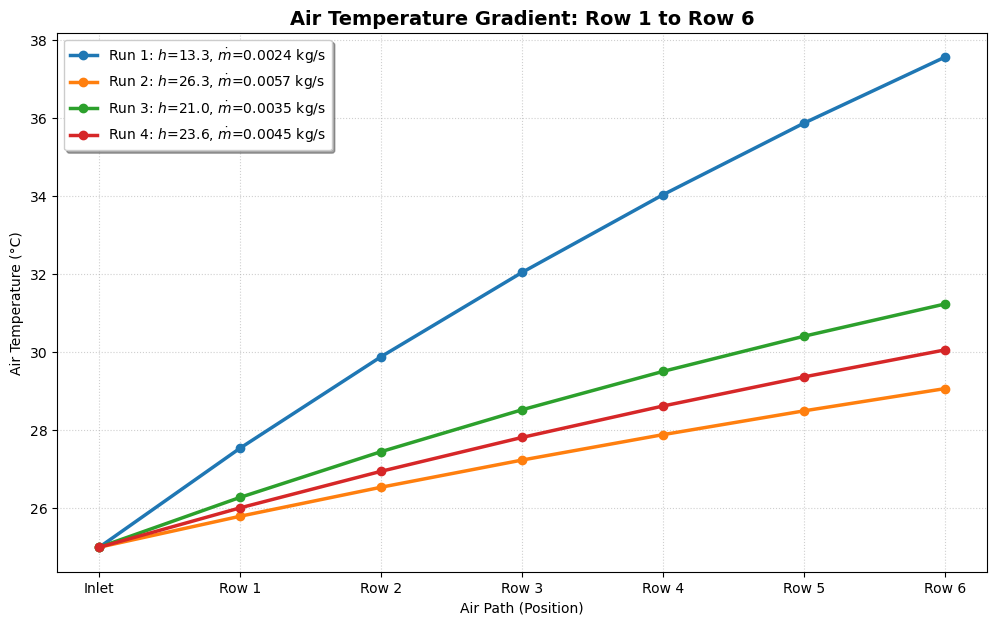

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import os

# ==========================================
# 1. USER SETTINGS & MANUAL TUNING
# ==========================================
files = [
    {"path": "251223_2312_1Hz_2_75WServer10k.csv", "label": "Run 1", "desc": "2.75W Server", "power": 2.75, "offset": -0.9, "stop_time": 4500},
    {"path": "251228_2327_2Hz_16w10kfan.csv",      "label": "Run 2", "desc": "16W Fan",      "power": 16.0, "offset": -1.0, "stop_time": 2050},
    {"path": "251229_1926_2Hz_6W_10kFan.csv",       "label": "Run 3", "desc": "6W Fan",       "power": 6.0,  "offset": -1.0, "stop_time": 2300},
    {"path": "251230_0004_2Hz_10w_10kFan.csv",      "label": "Run 4", "desc": "10W Fan",      "power": 10.0, "offset": -1.0, "stop_time": 2050}
]

# Physical Constants
n_cells = 5
mc_total = ((n_cells * (47 + 2)) / 1000) * 900 
exposed_factor = 0.90 
total_area = (n_cells * (np.pi * (18/1000) * (55/1000))) * exposed_factor

# Smoothing Params
sigma_val, window_size, h_smooth_window, poly_order = 15, 501, 401, 2

# Storage for later plots
comparison_data = []
simulation_inputs = [] # <--- NEW: Initialize storage for air temp simulation

# ==========================================
# 2. MAIN PROCESSING LOOP
# ==========================================
for run in files:
    if not os.path.exists(run['path']):
        print(f"❌ Skipping {run['path']}: File not found.")
        continue

    # Load and Clean
    df = pd.read_csv(run['path'], names=['time_ms', 'v_thermistor', 'temp_battery', 'temp_ambient', 'v_ups', 'v_battery'], skiprows=1)
    for col in ['time_ms', 'temp_battery', 'temp_ambient', 'v_battery']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['time_ms', 'temp_battery']).copy()
    
    df['time_sec'] = (df['time_ms'] - df['time_ms'].iloc[0]) / 1000
    split_idx = df['temp_battery'].idxmax()

    # Smoothing
    temp_blurred = gaussian_filter1d(df['temp_battery'], sigma=sigma_val)
    df['temp_bat_smooth'] = savgol_filter(temp_blurred, window_size, poly_order)
    df['dT_dt'] = savgol_filter(temp_blurred, window_size, poly_order, deriv=1, delta=1.0)
    
    amb_blurred = gaussian_filter1d(df['temp_ambient'] + run['offset'], sigma=sigma_val)
    df['temp_amb_smooth'] = savgol_filter(amb_blurred, window_size, poly_order)
    df['v_bat_smooth'] = savgol_filter(df['v_battery'].ffill(), 51, 2)

    # Physics Stage
    df_settle = df.iloc[split_idx:].copy()
    df_settle = df_settle[df_settle['time_sec'] <= run['stop_time']]
    df_settle = df_settle[(df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']) > 0.1]
    
    df_settle['delta_T'] = df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']
    raw_h = -(mc_total * df_settle['dT_dt']) / (total_area * df_settle['delta_T'])
    
    actual_h_win = min(len(df_settle)-1, h_smooth_window)
    if actual_h_win % 2 == 0: actual_h_win -= 1
    df_settle['h_coeff'] = savgol_filter(raw_h, actual_h_win, poly_order) if actual_h_win > 2 else raw_h
    
    median_h = df_settle['h_coeff'].median()
    
    # --- NEW: STORE DATA FOR AIR TEMP SIMULATION ---
    simulation_inputs.append({
        'label': run['label'],
        'h': median_h,
        't_max': df['temp_battery'].max(),
        'power': run['power']
    })

    # (Optional: Keep your individual plots here if you want them to generate)
    comparison_data.append({'label': run['label'], 'time': df_settle['time_sec'], 'h': df_settle['h_coeff'], 'median': median_h})

# ==========================================
# 3. ROW-BY-ROW AIR TEMPERATURE GRAPH
# ==========================================
n_rows = 6
cells_per_row = 5
area_per_row = cells_per_row * (np.pi * (18/1000) * (55/1000)) * 0.90
cp_air, rho_air, t_room = 1006, 1.225, 25.0

plt.figure(figsize=(12, 7))

for data in simulation_inputs:
    # m_dot estimate: mass flow scales with power. Adjust 0.0045 to tune baseline CFM.
    m_dot = 0.0045 * (data['power'] / 10.0)**(0.5) 
    
    row_temps = [t_room]
    current_air_temp = t_room
    
    for r in range(n_rows):
        # Q_conv = h * A * delta_T
        q_row = data['h'] * area_per_row * (data['t_max'] - current_air_temp)
        
        # Physics Check: Energy balance limit (air can't exceed battery temp)
        q_limit = m_dot * cp_air * (data['t_max'] - current_air_temp)
        q_actual = min(q_row, q_limit)
        
        dt_air = q_actual / (m_dot * cp_air)
        current_air_temp += dt_air
        row_temps.append(current_air_temp)

    legend_label = rf"{data['label']}: $h$={data['h']:.1f}, $\dot{{m}}$={m_dot:.4f} kg/s"
    plt.plot(range(n_rows + 1), row_temps, marker='o', linewidth=2.5, label=legend_label)

plt.title("Air Temperature Gradient: Row 1 to Row 6", fontsize=14, fontweight='bold')
plt.xlabel("Air Path (Position)")
plt.ylabel("Air Temperature (°C)")
plt.xticks(range(n_rows + 1), ['Inlet', 'Row 1', 'Row 2', 'Row 3', 'Row 4', 'Row 5', 'Row 6'])
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.show()

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import os

# --- 1. FILE LIST & RUN-SPECIFIC TUNING ---
files = [
    {"path": "251223_2312_1Hz_2_75WServer10k.csv", "label": "Run 1", "desc": "2.75W Server", "power": 2.75, "offset": -0.9, "stop_time": 4500},
    {"path": "251228_2327_2Hz_16w10kfan.csv",      "label": "Run 2", "desc": "16W Fan",      "power": 16.0, "offset": -1.0, "stop_time": 2050},
    {"path": "251229_1926_2Hz_6W_10kFan.csv",       "label": "Run 3", "desc": "6W Fan",       "power": 6.0,  "offset": -1.0, "stop_time": 2300},
    {"path": "251230_0004_2Hz_10w_10kFan.csv",      "label": "Run 4", "desc": "10W Fan",      "power": 10.0, "offset": -1.0, "stop_time": 2050}
]

# --- 2. GLOBAL PHYSICAL CONSTANTS ---
n_cells = 5
mc_total = ((n_cells * (47 + 2)) / 1000) * 900 
exposed_factor = 0.90 
total_area = (n_cells * (np.pi * (18/1000) * (55/1000))) * exposed_factor

# Simulation Constants
n_rows = 6
cells_per_row = 5
area_per_row = cells_per_row * (np.pi * (18/1000) * (55/1000)) * exposed_factor
cp_air, rho_air, t_room = 1006, 1.225, 25.0

# --- 3. GLOBAL SMOOTHING PARAMETERS ---
sigma_val = 15
window_size = 501
h_smooth_window = 401
poly_order = 2

# Global storage to communicate between blocks
processed_results = []

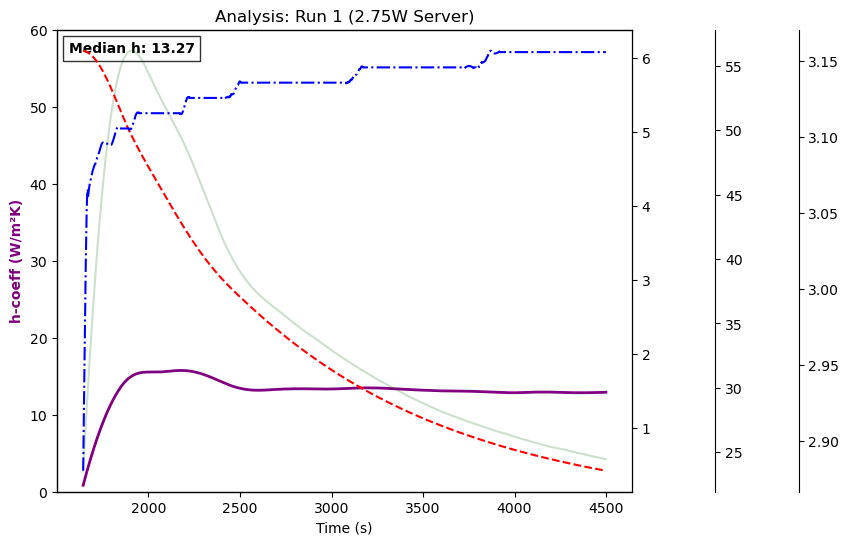

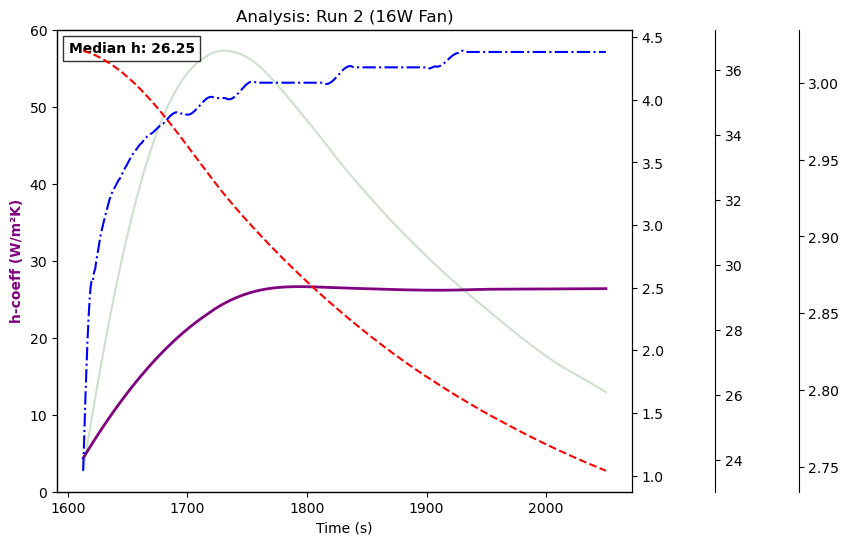

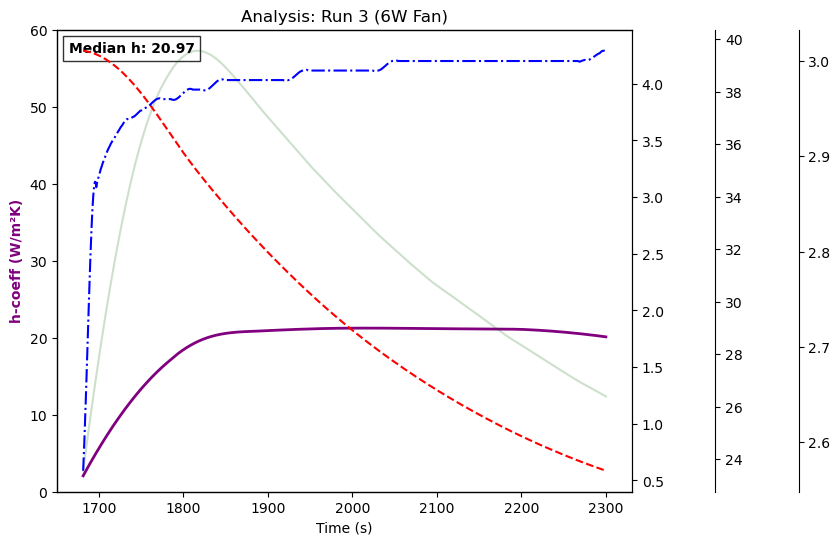

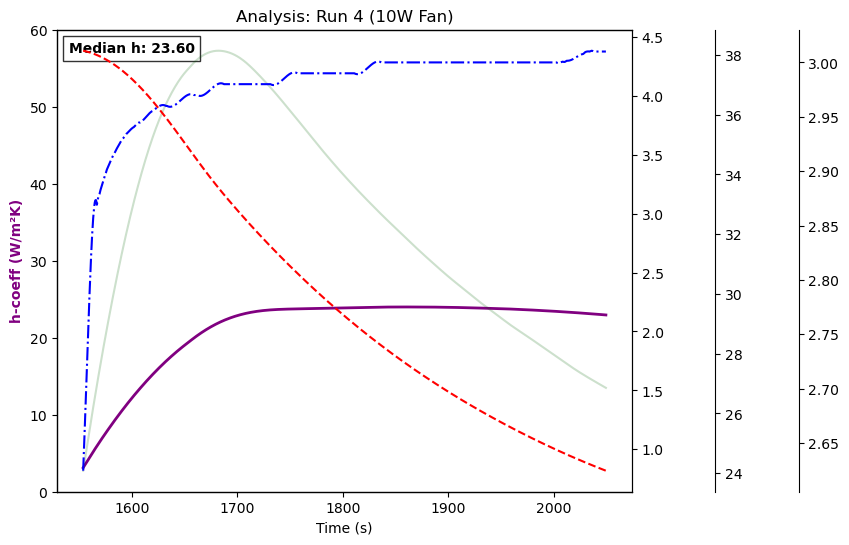

In [48]:
processed_results = [] # Reset storage

for run in files:
    if not os.path.exists(run['path']):
        print(f"❌ Skipping {run['path']}: File not found.")
        continue

    # Load and Clean
    df = pd.read_csv(run['path'], names=['time_ms', 'v_thermistor', 'temp_battery', 'temp_ambient', 'v_ups', 'v_battery'], skiprows=1)
    for col in ['time_ms', 'temp_battery', 'temp_ambient', 'v_battery']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['time_ms', 'temp_battery']).copy()
    
    df['time_sec'] = (df['time_ms'] - df['time_ms'].iloc[0]) / 1000
    split_idx = df['temp_battery'].idxmax()

    # Smoothing
    temp_blurred = gaussian_filter1d(df['temp_battery'], sigma=sigma_val)
    df['temp_bat_smooth'] = savgol_filter(temp_blurred, window_size, poly_order)
    df['dT_dt'] = savgol_filter(temp_blurred, window_size, poly_order, deriv=1, delta=1.0)
    
    amb_blurred = gaussian_filter1d(df['temp_ambient'] + run['offset'], sigma=sigma_val)
    df['temp_amb_smooth'] = savgol_filter(amb_blurred, window_size, poly_order)
    df['v_bat_smooth'] = savgol_filter(df['v_battery'].ffill(), 51, 2)

    # Physics Stage (Settling)
    df_settle = df.iloc[split_idx:].copy()
    df_settle = df_settle[df_settle['time_sec'] <= run['stop_time']]
    df_settle = df_settle[(df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']) > 0.1]
    
    df_settle['delta_T'] = df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']
    raw_h = -(mc_total * df_settle['dT_dt']) / (total_area * df_settle['delta_T'])
    
    actual_h_win = min(len(df_settle)-1, h_smooth_window)
    if actual_h_win % 2 == 0: actual_h_win -= 1
    df_settle['h_coeff'] = savgol_filter(raw_h, actual_h_win, poly_order) if actual_h_win > 2 else raw_h
    df_settle['watts_loss'] = df_settle['h_coeff'] * total_area * df_settle['delta_T']

    median_h = df_settle['h_coeff'].median()
    
    # Store data for Block 3 (Removes manual hardcoding)
    processed_results.append({
        'label': run['label'],
        'power': run['power'],
        'h': median_h,
        't_max': df['temp_battery'].max(),
        'time_series': df_settle['time_sec'],
        'h_series': df_settle['h_coeff']
    })

    # --- FOUR-AXIS INDIVIDUAL PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    fig.subplots_adjust(right=0.7) 
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('h-coeff (W/m²K)', color='purple', fontweight='bold')
    p1, = ax1.plot(df_settle['time_sec'], df_settle['h_coeff'], color='purple', linewidth=2, label='h-coeff')
    ax1.set_ylim(0, 60)
    
    ax1.text(0.02, 0.95, f'Median h: {median_h:.2f}', transform=ax1.transAxes, fontweight='bold', bbox=dict(facecolor='white', alpha=0.8))

    ax2, ax3, ax4 = ax1.twinx(), ax1.twinx(), ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax4.spines['right'].set_position(('outward', 120))
    ax2.plot(df_settle['time_sec'], df_settle['watts_loss'], color='darkgreen', alpha=0.2)
    ax3.plot(df_settle['time_sec'], df_settle['temp_bat_smooth'], color='red', linestyle='--')
    ax4.plot(df_settle['time_sec'], df_settle['v_bat_smooth'], color='blue', linestyle='-.')
    
    plt.title(f'Analysis: {run["label"]} ({run["desc"]})')
    plt.show()

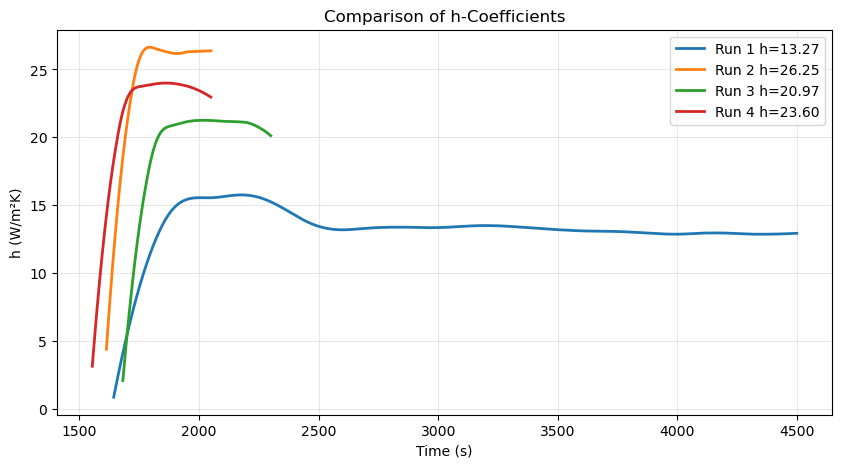

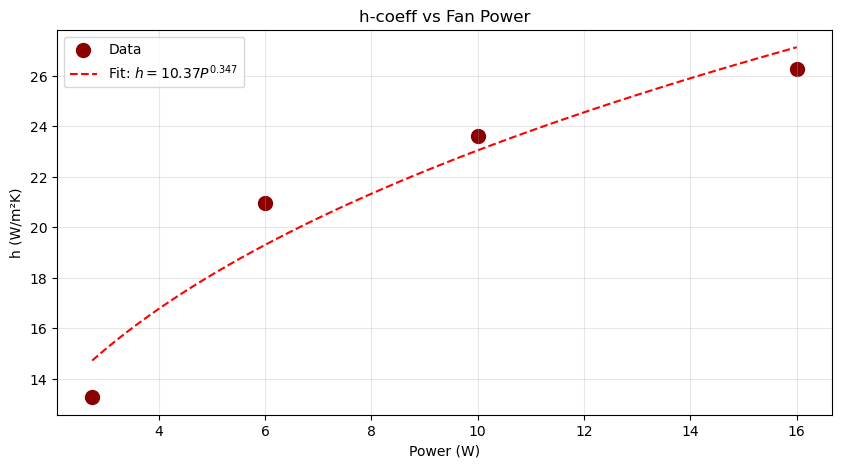

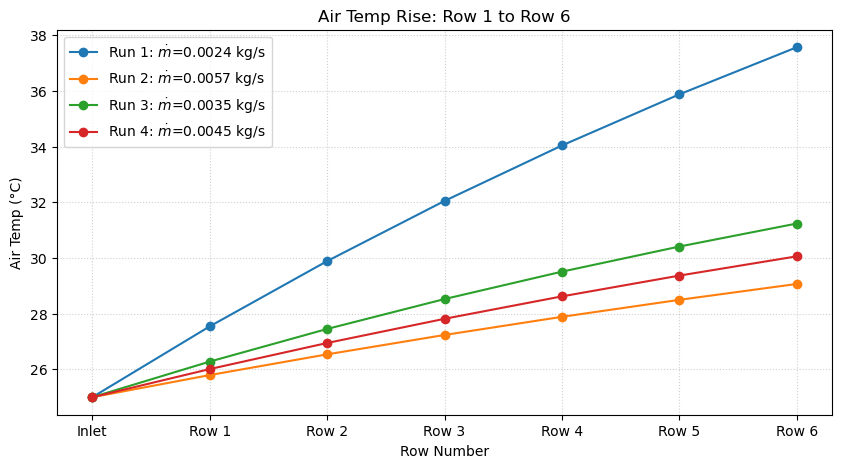

In [50]:
# --- 1. OVERLAY COMPARISON ---
plt.figure(figsize=(10, 5))
for res in processed_results:
    plt.plot(res['time_series'], res['h_series'], label=f"{res['label']} h={res['h']:.2f}", linewidth=2)
plt.title("Comparison of h-Coefficients")
plt.xlabel("Time (s)")
plt.ylabel("h (W/m²K)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 2. POWER LAW FIT (Automatic Reference) ---
x_data = np.array([res['power'] for res in processed_results])
y_data = np.array([res['h'] for res in processed_results])

# Sort by power for plotting
sort_idx = np.argsort(x_data)
x_data, y_data = x_data[sort_idx], y_data[sort_idx]

def power_law(P, a, b): 
    return a * np.power(P, b)

# Fit the model
popt, _ = curve_fit(power_law, x_data, y_data, p0=[5, 0.46])

plt.figure(figsize=(10, 5))
plt.scatter(x_data, y_data, color='darkred', s=100, label='Data')
x_smooth = np.linspace(x_data.min(), x_data.max(), 100)

# FIXED: Changed 'n--' to 'r--' (red dashed line)
plt.plot(x_smooth, power_law(x_smooth, *popt), 'r--', label=f'Fit: $h = {popt[0]:.2f} P^{{{popt[1]:.3f}}}$')

plt.title("h-coeff vs Fan Power")
plt.xlabel("Power (W)")
plt.ylabel("h (W/m²K)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 3. AIR TEMP GRADIENT SIMULATION ---
plt.figure(figsize=(10, 5))
for res in processed_results:
    # m_dot estimate: mass flow scales with power.
    m_dot = 0.0045 * (res['power'] / 10.0)**(0.5) 
    row_temps = [t_room]
    curr_t = t_room
    for _ in range(n_rows):
        q_row = res['h'] * area_per_row * (res['t_max'] - curr_t)
        q_limit = m_dot * cp_air * (res['t_max'] - curr_t)
        curr_t += min(q_row, q_limit) / (m_dot * cp_air)
        row_temps.append(curr_t)
    
    # FIXED: Added rf"" to legend_label to handle LaTeX safely
    legend_label = rf"{res['label']}: $\dot{{m}}$={m_dot:.4f} kg/s"
    plt.plot(range(n_rows + 1), row_temps, marker='o', label=legend_label)

plt.title("Air Temp Rise: Row 1 to Row 6")
plt.xlabel("Row Number")
plt.ylabel("Air Temp (°C)")
plt.xticks(range(n_rows+1), ['Inlet', 'Row 1', 'Row 2', 'Row 3', 'Row 4', 'Row 5', 'Row 6'])
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()